In [1]:
from scipy.stats import linregress
from netCDF4 import Dataset
import cartopy.crs as ccrs
import matplotlib.animation as animation
from IPython import display
import cartopy
import pickle
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pandas as pd
import tqdm
import mask
from regrid import regrid
from cartoplot import cartoplot

/home/robbie/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/robbie/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))


# get lon/lat coords and mask

In [2]:
import xarray as xr
import numpy as np

In [5]:
# d1a = Dataset('../toolbox_output/partial_1_a.nc')
# d1b = Dataset('../toolbox_output/partial_1_b.nc')
# d2a = Dataset('../toolbox_output/partial_2_a.nc')
# d2b = Dataset('../toolbox_output/partial_2_b.nc')

d1a = Dataset('../toolbox_output/p1a.nc')
d1b = Dataset('../toolbox_output/p1b.nc')
d2a = Dataset('../toolbox_output/p2a.nc')
d2b = Dataset('../toolbox_output/p2b.nc')

dates_1 = [datetime.date(1979,10,1) + datetime.timedelta(days=int(days_since)) for days_since in np.array(d1a['time'])] 
dates_2 = [datetime.date(1979,1,1) + datetime.timedelta(days=int(days_since)) for days_since in np.array(d2a['time'])] 

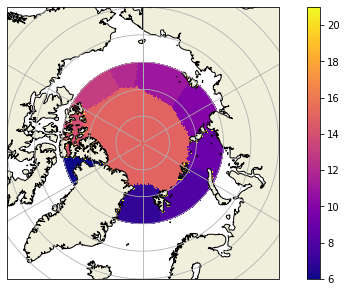

In [7]:
d = d1a

lon = d['lon']
lat = d['lat']

elons = mask.get('lon')
elats = mask.get('lat')
emask = mask.get('mask')

lon_grid, lat_grid = np.meshgrid(lon,lat)

era_mask = regrid(emask,elons,elats,lon_grid,lat_grid)

era_mask[lat_grid < 75] = np.nan

cartoplot(lon_grid,lat_grid,era_mask)

cos_lats = np.cos(np.deg2rad(lat_grid))

cos_lats_3d = np.repeat(cos_lats[np.newaxis,:,:],3,axis=0)

In [8]:
def process_data(data):
    
    # Set values outside Central Arctic to nan
    
    data[era_mask != 15] = np.nan

    # weight the data for more numerous grid cells near pole
    
    val_data = data[~np.isnan(data)]
    weights = cos_lats[~np.isnan(data)]

    sum_for_year = np.average(val_data,weights=weights)
    
    return(sum_for_year)

def get_data_lists(d1,d2,mode):

    data_10_12 = []
    
    if mode == 'winter':
        early_list = [10,11,12]
        late_list = [1,2,3,4]
    elif mode == 'cold-season':
        early_list = [12]
        late_list = [1,2]

    for counter, date in enumerate(dates_1):

        if date.month in early_list:

            data_10_12.append(d1['data'][counter])

    data_1_4 = []

    for counter, date in enumerate(dates_2):

        if date.month in late_list:

            data_1_4.append(d2['data'][counter])
            
    return (data_10_12,data_1_4)

def get_sums(d1,d2,mode='cold-season'):
    
    data_10_12,data_1_4 = get_data_lists(d1,d2,mode)

    anns = []
    
    if mode == 'winter':
        early_step = 3
        late_step = 4
    elif mode == 'cold-season':
        early_step = 1
        late_step = 2

    for i, j in zip(range(0,len(data_10_12),early_step),
                    range(0,len(data_1_4),late_step)):

        ave =np.sum(data_10_12[i:i+early_step]+data_1_4[j:j+late_step],axis=0)

        anns.append(ave)

    sums = []

    for i in anns:

        p = process_data(i)

        sums.append(p)
        
    return(sums)

In [ ]:
sums_a_winter = get_sums(d1a,d2a, mode='winter')
sums_b_winter = get_sums(d1b,d2b, mode='winter')
sums_a_cs = get_sums(d1a,d2a, mode='cold-season')
sums_b_cs = get_sums(d1b,d2b, mode='cold-season')

years=np.arange(1979,2021)

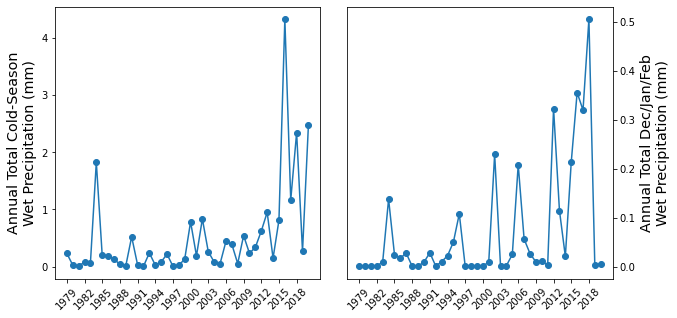

In [12]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
    
ax1.plot(years,sums_a_winter,marker='o',label='> 0.1 mm/day rate')
ax2.plot(years,sums_a_cs,marker='o',label='> 0.1 mm/day rate')

ax1.set_ylabel('Annual Total Cold-Season\nWet Precipitation (mm)',fontsize='x-large')
ax2.set_ylabel('Annual Total Dec/Jan/Feb\nWet Precipitation (mm)',fontsize='x-large')
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")


ax1.set_xticks(list(years)[::3])
ax1.set_xticklabels(list(years)[::3],rotation=45)

ax2.set_xticks(list(years)[::3])
ax2.set_xticklabels(list(years)[::3],rotation=45)

# ax1.legend()

plt.subplots_adjust(wspace=0.1)

plt.savefig('../ROS_trends_toolbox.png',dpi=500,bbox_inches='tight')

obj = (years,sums_a_winter, sums_a_cs)

pickle.dump(obj, open('../pickles/trends.p', 'wb'))